<a href="https://colab.research.google.com/github/Biswajitnahak2003/snn-glacier-segmentation/blob/main/week3/updated_week1%262.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install rasterio

--- Data Pipeline Complete and Ready for Training ---

Verifying the DataLoader by showing one batch...
Shape of one batch of images: torch.Size([4, 5, 256, 256])
Shape of one batch of masks: torch.Size([4, 1, 256, 256])


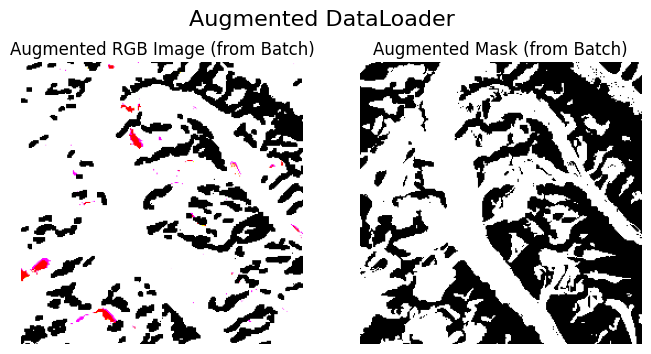

In [ ]:
# --- =================================================================== ---
# --- Consolidated Data Pipeline (Week 1 & 2) with Augmentation           ---
# --- =================================================================== ---

# --- Step 1: Imports ---
# We are adding 'albumentations' for powerful data augmentation as we have only 25 images in train
import os
import glob
import torch
from torch.utils.data import Dataset, DataLoader
import rasterio
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

# --- Step 2: The Final GlacierDataset Class ---
# This class combines loading, stacking, and augmenting data.
class GlacierDataset(Dataset):
    def __init__(self, base_path, image_ids, augmentations=None):
        """
        Constructor.
        Args:
            base_path (str): Path to the 'train' directory.
            image_ids (list): List of label filenames for this dataset split.
            augmentations (albumentations.Compose): The augmentation pipeline.
        """
        super().__init__()
        self.base_path = base_path
        self.image_ids = image_ids
        self.augmentations = augmentations

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.image_ids)

    def __getitem__(self, idx):
        """Loads, processes, and returns one sample (image and mask)."""
        label_filename = self.image_ids[idx]

        identifier = f"_{os.path.basename(label_filename).split('_')[-2]}_{os.path.basename(label_filename).split('_')[-1]}"
        band_folders = ['Band1', 'Band2', 'Band3', 'Band4', 'Band5']

        layer_paths = [glob.glob(os.path.join(self.base_path, f, f'*{identifier}'))[0] for f in band_folders]

        image_layers = [rasterio.open(path).read(1) for path in layer_paths]

        image = np.stack(image_layers, axis=-1)

        mask_path = os.path.join(self.base_path, 'label', label_filename)
        with rasterio.open(mask_path) as src:
            mask = src.read(1)

        if self.augmentations:
            augmented = self.augmentations(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask.unsqueeze(0) # Add a channel dimension for the mask

# --- Step 3: Define the Augmentation Pipelines ---
train_augmentations = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Normalize(mean=(0.5, 0.5, 0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5, 0.5, 0.5)), # Normalizes pixel values
    ToTensorV2(),
])

val_augmentations = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.5, 0.5, 0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5, 0.5, 0.5)),
    ToTensorV2(),
])

# --- Step 4: Create the DataLoaders ---
TRAIN_DATA_PATH = '/content/drive/MyDrive/GlacierHack_practice/train'

all_label_files = sorted(os.listdir(os.path.join(TRAIN_DATA_PATH, 'label')))
train_ids = all_label_files[:20]
val_ids = all_label_files[20:]

train_dataset = GlacierDataset(TRAIN_DATA_PATH, train_ids, augmentations=train_augmentations)
val_dataset = GlacierDataset(TRAIN_DATA_PATH, val_ids, augmentations=val_augmentations)

train_loader = DataLoader(dataset=train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=4, shuffle=False)

print("--- Data Pipeline Complete and Ready for Training ---")

# --- Step 5: Verification and Visualization ---
print("\nVerifying the DataLoader by showing one batch...")
images_batch, masks_batch = next(iter(train_loader))

print(f"Shape of one batch of images: {images_batch.shape}")
print(f"Shape of one batch of masks: {masks_batch.shape}")

# Visualize one sample from the batch
first_image = images_batch[0]
first_mask = masks_batch[0]

rgb_image = first_image[[3, 2, 1], :, :]
rgb_for_plot = np.moveaxis(rgb_image.numpy(), 0, -1)

mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])
rgb_for_plot = std * rgb_for_plot + mean
rgb_for_plot = np.clip(rgb_for_plot, 0, 1)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(rgb_for_plot)
axes[0].set_title("Augmented RGB Image (from Batch)")
axes[0].axis('off')

axes[1].imshow(first_mask.squeeze(), cmap='gray')
axes[1].set_title("Augmented Mask (from Batch)")
axes[1].axis('off')

plt.suptitle("Augmented DataLoader", fontsize=16)
plt.show()